In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle
import logging
import sys
from sklearn.utils import class_weight

In [37]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Lambda, BatchNormalization, \
    CuDNNLSTM, Bidirectional, Input, concatenate, Flatten, RepeatVector, Activation, Multiply, Permute
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import tensorflow as tf

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# only reserve 1 GPU

In [4]:
# tf.enable_eager_execution()

In [5]:
logger = logging.getLogger('training')
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.setLevel(logging.DEBUG)

# Read data

In [6]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [7]:
# root_dir = '/home/anasab/' 
root_dir = '/home/ana/'

### eRisk 2020 T1

In [8]:
datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [9]:
def read_texts_2020(datadir_T1, labels_file_T1):
    writings = []
    for subject_file in os.listdir(datadir_T1):
        print(subject_file)
        writings.extend(read_subject_writings(os.path.join(datadir_T1, subject_file)))
    writings_df = pd.DataFrame(writings)

    labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])
    labels_T1 = labels_T1.set_index('subject')

    writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])
    
    return writings_df



### eRisk 2019 T1 (Anorexia)

In [10]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [11]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset=='train':
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

## Preprocess text

In [12]:
# writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
writings_df = pickle.load(open('writings_df_selfharm_liwc', 'rb'))

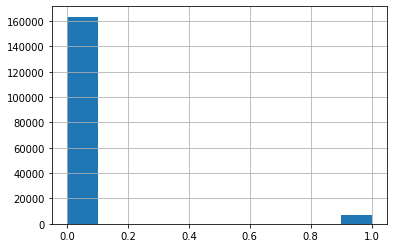

In [13]:
writings_df.label.hist()

In [14]:
writings_df.head()

,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len,all_tokens,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0,"[if, anyone, could, help, with, which, sub, to...",11.0,None,NaN,"[if, anyone, could, help, with, which, sub, to...",...,0.0,0.090909,0.090909,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0,"[i, m, literally, never, gonna, stop, waiting]",7.0,None,NaN,"[i, m, literally, never, gonna, stop, waiting]",...,0.0,0.000000,0.285714,0.0,0.142857,0.00000,0.142857,0.00000,0.0,0.0
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0,"[this, is, a, really, interesting, study, make...",9.0,None,NaN,"[this, is, a, really, interesting, study, make...",...,0.0,0.111111,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0,"[the, only, thing, frank, is, building]",6.0,"[is, hype, think, about, it, every, time, he, ...",26.0,"[is, hype, think, about, it, every, time, he, ...",...,0.0,0.000000,0.062500,0.0,0.062500,0.03125,0.000000,0.03125,0.0,0.0
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0,"[mostly, always, me, during, this, whole, char...",7.0,None,NaN,"[mostly, always, me, during, this, whole, char...",...,0.0,0.000000,0.000000,0.0,0.142857,0.00000,0.142857,0.00000,0.0,0.0


In [15]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [16]:
def tokenize_fields(writings_df):
    writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) 
                                                                if type(t)==str and t else None)
    writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) 
                                                                    if type(t)==list and t else None)
    writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) 
                                                              if type(t)==str and t else None)
    writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) 
                                                                  if type(t)==list and t else None)
    return writings_df

In [17]:
writings_df.text_len.describe()

count    127941.000000
mean         32.268929
std          82.590713
min           0.000000
25%           6.000000
50%          13.000000
75%          31.000000
max        7201.000000
Name: text_len, dtype: float64

In [18]:
writings_df.title_len.describe()

count    49762.000000
mean        10.699771
std          9.282454
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        149.000000
Name: title_len, dtype: float64

In [19]:
writings_df.groupby('subject').mean().describe()

,label,title_len,text_len,funct,article,affect,negemo,sad,cogmech,inhib,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
count,340.000000,336.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,...,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,0.120588,9.514427,33.122855,0.425434,0.049284,0.080990,0.023242,0.003515,0.125608,0.004730,...,0.005483,0.022510,0.089113,0.002740,0.079820,0.008573,0.040263,0.004642,0.020469,0.005873
std,0.326128,4.714271,31.874155,0.085804,0.013413,0.032889,0.011015,0.002891,0.031706,0.002874,...,0.004131,0.009740,0.028436,0.004729,0.027475,0.007100,0.020218,0.004367,0.012310,0.004040
min,0.000000,1.000000,1.000000,0.018182,0.005237,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.601190,14.402079,0.379003,0.042321,0.063090,0.016110,0.001949,0.109709,0.002829,...,0.003234,0.016795,0.073775,0.000669,0.064952,0.004052,0.027496,0.002302,0.013474,0.003566
50%,0.000000,8.660264,24.212121,0.439643,0.049415,0.074207,0.022189,0.002867,0.127451,0.004594,...,0.004879,0.022203,0.088307,0.001581,0.077149,0.006945,0.037420,0.003735,0.018725,0.005123
75%,0.000000,11.526931,37.878342,0.478550,0.057188,0.090063,0.028348,0.004319,0.145710,0.006224,...,0.006712,0.027300,0.105534,0.002902,0.093965,0.011430,0.049840,0.005544,0.025045,0.007488
max,1.000000,32.166667,266.446446,0.646948,0.095561,0.270520,0.073699,0.020833,0.251136,0.022180,...,0.042094,0.090475,0.202499,0.045799,0.213871,0.069447,0.133143,0.037712,0.099026,0.041093


In [20]:
writings_df.groupby('subject').max().groupby('label').count()

,date,title_len,text_len,all_tokens,funct,article,affect,negemo,sad,cogmech,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
label,,,,,,,,,,,,,,,,,,,,,
0,299,296,299,299,299,299,299,299,299,299,...,299,299,299,299,299,299,299,299,299,299
1,41,40,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41


In [21]:
print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of posts per user 146.35882352941175
Average number of comments per user 376.2970588235294


In [22]:
writings_df.groupby('subject').count().title.describe()

count    340.000000
mean     146.358824
std      240.998992
min        0.000000
25%       13.000000
50%       42.500000
75%      148.500000
max      998.000000
Name: title, dtype: float64

In [23]:
writings_df.groupby('subject').count().text.describe()

count     340.000000
mean      376.297059
std       379.091730
min         1.000000
25%        54.000000
50%       214.500000
75%       646.000000
max      1350.000000
Name: text, dtype: float64

# Recurrent NN

## Extract features and encode data

In [24]:
hyperparams_features = {
    "max_features": 40000,
    # cut texts after this number of words
    # (among top max_features most common words)
    "maxlen": 500,
    "embedding_dim": 100,
    "user_level": True,
}


### Emotions

In [25]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [26]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative:
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [27]:
from liwc_readDict import readDict

liwc = readDict(root_dir + '/resources/liwc.dic')

categories = set([c for (w,c) in liwc])
len(categories)

64

### Style features

#### Char n-grams

In [28]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [29]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return np.nan
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [30]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

### Encode data

In [89]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, seq_len, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, test_slice=2,
                    nr_slices=5,
                    min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None,
                   logger=logger):
    logger.debug("Loading data...\n")
    if not vocabulary:
        vocabulary = {}
        word_freqs = Counter()
        for words in writings_df.tokenized_text:
            word_freqs.update(words)
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
        i = 1
        for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
            if len(w) < min_word_len:
                continue
            vocabulary[w] = i
            i += 1
    tokens_data_train = []
    categ_data_train = []
    sparse_data_train = []
    tokens_data_valid = []
    categ_data_valid = []
    sparse_data_valid = []
    tokens_data_test = []
    categ_data_test = []
    sparse_data_test = []
    labels_train = []
    users_train = []
    labels_valid = []
    users_valid = []
    users_test = []
    labels_test = []
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}

    user_level_texts = {}
    for row in writings_df.sort_values(by='date').itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
        else:
            user_level_texts[row.subject]['texts'].append(words)
            user_level_texts[row.subject]['liwc'].append(liwc_categs)
    return user_level_texts, subjects_split, vocabulary

#     for subject in user_level_texts.keys():
#         texts = user_level_texts[subject]['texts']
#         label = user_level_texts[subject]['label']
#         if user_level:
#             all_words = [sum(texts, [])] # merge all texts in one list
#             liwc_aggreg = [np.array(user_level_texts[subject]['liwc']).mean(axis=0).tolist()]
#         else:
#             all_words = texts
#             liwc_aggreg = user_level_texts[subject]['liwc']
#         for i, words in enumerate(all_words):
#             encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = encode_text(words)
#             subject_id = int(subject.split('t')[1])
#             if subject in training_subjects:
#                 tokens_data_train.append(encoded_tokens)
#                 categ_data_train.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
#                 sparse_data_train.append(encoded_stopwords)
#                 labels_train.append(label)
#                 users_train.append(subject_id)
#             elif subject in valid_subjects:
#                 tokens_data_valid.append(encoded_tokens)
#                 categ_data_valid.append(encoded_emotions + [encoded_pronouns]  + liwc_aggreg[i])
#                 sparse_data_valid.append(encoded_stopwords)
#                 labels_valid.append(label)
#                 users_valid.append(subject_id)
#             else:
#                 tokens_data_test.append(encoded_tokens)
#                 categ_data_test.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
#                 sparse_data_test.append(encoded_stopwords)
#                 labels_test.append(label)
#                 users_test.append(subject_id)
        
#     # using zeros for padding
#     tokens_data_train_padded = sequence.pad_sequences(tokens_data_train, maxlen=seq_len)
#     tokens_data_valid_padded = sequence.pad_sequences(tokens_data_valid, maxlen=seq_len)
#     tokens_data_test_padded = sequence.pad_sequences(tokens_data_test, maxlen=seq_len)
        
#     return ([np.array(tokens_data_train_padded), np.array(categ_data_train), np.array(sparse_data_train),
#             np.array(users_train)],
#             np.array(labels_train)), \
#             ([np.array(tokens_data_valid_padded),
#               np.array(categ_data_valid), np.array(sparse_data_valid),
#             np.array(users_valid)],
#             np.array(labels_valid)), \
#             ([np.array(tokens_data_test_padded), np.array(categ_data_test), np.array(sparse_data_test),
#              np.array(users_test)],
#              np.array(labels_test)), vocabulary

In [90]:
user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            seq_len=hyperparams_features['maxlen'],
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger
#                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                               )

Loading data...

start index: 136.000000, from 0.600000

166 training users, 71 validation users, 103 test users.


### Data Generator

In [193]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, set_type='train',
                 batch_size=32, seq_len=500, voc_size=40000, emotion_lexicon=nrc_lexicon,
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], max_posts_per_user=10,
                 shuffle=True):
        'Initialization'
        self.seq_len = seq_len
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.data = user_level_data
        self.emotions = emotions
        self.pronouns = pronouns
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.max_posts_per_user = max_posts_per_user
        self.on_epoch_end()

    def __encode_text(self, tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.subjects_split[self.set]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        user_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find users
        users = [self.subjects_split[self.set][i] for i in user_indexes]

        post_indexes = {}
        # Sample post ids
        for subject in users:
            posts_len = len(self.data[subject])
            posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         min(self.max_posts_per_user, posts_len),
                                                         replace=False))
            post_indexes[subject] = posts_index_sample
        # Generate data
        X, y = self.__data_generation(users, post_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        labels = []
        for subject in users:
            texts = self.data[subject]['texts']
            label = self.data[subject]['label']
            
            # Sample
            texts = [texts[i] for i in post_indexes[subject]]
            all_words = [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = [np.array(self.data[subject]['liwc']).mean(axis=0).tolist()]

            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = self.__encode_text(words)
                subject_id = int(subject.split('t')[1])
                tokens_data.append(encoded_tokens)
                categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data.append(encoded_stopwords)
                labels.append(label)
                subjects.append(subject_id)

        
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len)

        return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                np.array(subjects)],
                np.array(labels))


In [194]:
logger.setLevel(logging.DEBUG)

# TODO: it is skipping the last batch

for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGenerator(user_level_data, subjects_split, 
                                          set_type=set_type):
        total_positive += pd.Series(y_train).sum()
    logger.info("%d %s positive examples\n" % (total_positive, set_type))


26 train positive examples

5 valid positive examples

9 test positive examples



In [195]:
item[0][2].shape

(32, 179)

In [196]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.57142857, 4.        ])

In [197]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], voc)


Total 40000 word vectors.


In [44]:
x_train[3].shape

(166,)

## Define model

In [198]:
hyperparams = {
    'lstm_units': 256,
    'dense_bow_units': 5,
    'dropout': 0.0,
    'l2_dense': 0.0000011,
    'l2_embeddings': 0.000001,
    'optimizer': 'adam',
    'decay': 0.0001,
    'lr': 0.001,
    "batch_size": 32,
    "trainable_embeddings": True,
    "reduce_lr_factor": 0.0002,
    "reduce_lr_patience": 50,
    "freeze_patience": 500,
    'threshold': 0.5,
    'ignore_layer': [],
    'norm_momentum': 0.3,

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])

In [199]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true
    return K.binary_crossentropy(y_labels, 
                                 y_pred)

metrics_class = Metrics(threshold=hyperparams['threshold'])

In [200]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):

    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
    if 'batchnorm' not in ignore_layer:
        embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='embeddings_layer_norm')(embedding_layer)
#     lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units']))(embedding_layer)

    if tf.test.is_gpu_available():
        lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                return_sequences='attention' not in ignore_layer, # only True if using attention
                      name='LSTM_layer')(embedding_layer)
    else:
        lstm_layers = LSTM(hyperparams['lstm_units'], 
                           return_sequences='attention' not in ignore_layer,
                      name='LSTM_layer')(embedding_layer)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units'])(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)

        
    else:
        sent_representation = lstm_layers
        
    
    sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    dense_layer = Dense(units=1,
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        name='numerical_dense_layer',
                       )(numerical_features)
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
    
    if 'batchnorm' not in ignore_layer:
        numerical_features_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        
    subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'lstm_layers': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse
    }
    if 'batchnorm' not in ignore_layer:
        all_layers = {
            'lstm_layers': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in ignore_layer:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']))(merged_layers)

    # Compile model
    model = Model(inputs=[tokens_features, numerical_features, sparse_features, subjects], 
                  outputs=output_layer)

    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
    return model



In [201]:
model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories=[c for c in categories if c in writings_df.columns]
,
                   ignore_layer=hyperparams['ignore_layer'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_seq (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embeddings_layer (Embedding)    (None, 500, 100)     4000000     word_seq[0][0]                   
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 500, 256)     365568      embeddings_layer[0][0]           
__________________________________________________________________________________________________
attention (Dense)    

In [257]:
# plot_model(model, 'models/lstm_plus_attention.png')

In [202]:
experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="mental", workspace="ananana")

experiment.log_parameters(hyperparams_features)

experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
experiment.log_parameter('emotions', emotions)
experiment.log_parameter('embeddings_path', pretrained_embeddings_path)
if 'subset' in writings_df.columns:
    experiment.add_tag('anorexia')

experiment.log_parameters(hyperparams)

COMET INFO: old comet version (3.0.2) detected. current: 3.1.0 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ananana/mental/63067179a5f349be819ce476a2d64b36



## Train

In [203]:
class WeightsHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.log_weights(0)

    def on_epoch_end(self, epoch, logs={}):
        self.log_weights(epoch)
        
    def log_weights(self, step):
        for layer in model.layers:
            try:
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer.name, step=step)
            except Exception as e:
                logger.debug("Logging weights error: " + str(e) + "\n")
                # Layer probably does not exist
                pass


class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer='embeddings_layer', verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        logging.debug("Trainable embeddings", model.get_layer(self.freeze_layer).trainable)
        if epoch == self.freeze_epoch:
            try:
                layer = model.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                # TODO: does this reset the optimizer?
                model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
                if self.verbose:
                    logging.debug("Setting %s layer from %s to trainable=%s...\n" % (layer.name, old_value,
                                                                   model.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [206]:
early_stopping_patience=50
def train_model(model, 
                data_generator_train, data_generator_valid,
                batch_size, epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                model_path='/tmp/model',
               verbose=1):
    logging.info('Train...')
    experiment.log_parameter('class_weight', class_weight.values())
    experiment.log_parameter('callbacks', callbacks)

    history = model.fit_generator(data_generator_train,
#               batch_size=batch_size,
                steps_per_epoch=100,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=data_generator_valid,
                        verbose=verbose,
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best' % model_path, verbose=1, 
                                          save_best_only=True),
                callbacks.EarlyStopping(patience=early_stopping_patience), *callback_list
            ])
    model.save(model_path)
    experiment.log_parameter('model_path', model_path)
    return model, history

In [ ]:
%%time

freeze_layer = FreezeLayer(patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
weights_history = WeightsHistory()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                          patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
data_generator_train = DataGenerator(user_level_data, subjects_split, set_type='train')
data_generator_valid = DataGenerator(user_level_data, subjects_split, set_type='valid')
model, history = train_model(model, data_generator_train, data_generator_valid,
           epochs=50, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      model_path='models/lstm_user_selfharm_att', workers=4)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range



Logging weights error: list index out of range



DEBUG:training:Logging weights error: list index out of range

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/50


In [167]:
model.evaluate(x_test, y_test)

103/103 [==============================] - 1s 10ms/sample - loss: 0.9224 - f1_m: 0.4902 - precision_m: 0.3849 - recall_m: 0.6875


[0.9223724927717042, 0.49020976, 0.38492063, 0.6875]

In [37]:
dependencies = {
    'f1_m': metrics_class.f1_m,
    'precision_m': metrics_class.precision_m,
    'recall_m': metrics_class.recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom
}
model = load_model(model_path, custom_objects=dependencies)


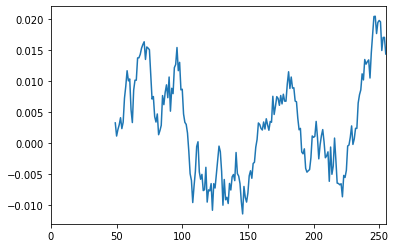

In [62]:
pd.Series([v for v in model.get_layer('attention').get_weights()[0].flatten()]).rolling(50).mean().plot()

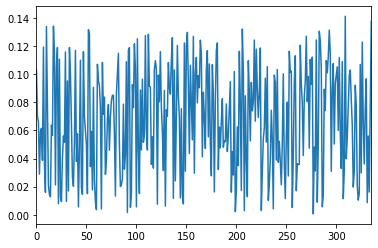

In [61]:
pd.Series([abs(v) for v in model.get_layer('output_layer').get_weights()[0].flatten()]).plot()

### Feature importance

In [84]:
features = [
    (e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories) if c in writings_df.columns] + [
(st, 'stopword') for st in stopword_list]
weights = model.get_layer('output_layer').get_weights()[0].tolist()[-(len(features)):]

print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

179 179


[(('himself', 'stopword'), -0.7284296154975891),
 (('against', 'stopword'), -0.677932858467102),
 (('themselves', 'stopword'), -0.6269885897636414),
 (('myself', 'stopword'), 0.5944074988365173),
 (('me', 'stopword'), 0.5808129906654358),
 (('which', 'stopword'), -0.5802603363990784),
 (('y', 'stopword'), -0.4890809953212738),
 (('yours', 'stopword'), -0.45802047848701477),
 (('shouldn', 'stopword'), -0.44473156332969666),
 (('herself', 'stopword'), -0.44048914313316345),
 (('ain', 'stopword'), 0.43934911489486694),
 (('as', 'stopword'), -0.42869824171066284),
 (('or', 'stopword'), 0.42340654134750366),
 (('by', 'stopword'), -0.4231763184070587),
 (('hasn', 'stopword'), -0.4093189239501953),
 (('from', 'stopword'), -0.40467941761016846),
 (('during', 'stopword'), -0.40312299132347107),
 (('no', 'stopword'), 0.39973184466362),
 (('am', 'stopword'), 0.39801648259162903),
 (('re', 'stopword'), -0.39346882700920105),
 (('once', 'stopword'), -0.3780168890953064),
 (('below', 'stopword'), -0

## Evaluate per user

In [85]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [86]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None,
                    random=False, nr_slices=5, test_slice=2):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        if random:
            sigma = np.std(outputs)
            mu = np.mean(outputs)
            print("generating random outputs with sigma", sigma, "and mu", mu)
            outputs = sigma*np.random.randn(len(outputs))+mu
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [87]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

Loading data...
0 training users,  0 validation users,  1  test users.
[417] [22] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[78] [7] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[496] [7] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1285] [62] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[172] [14] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[112] [0] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1231] [27] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1866] [10] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[282] [10] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[113] [1] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[478] [2] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[9] [0] 

[282] [7] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1039] [24] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[587] [4] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[95] [5] 0
Vote proportion 0.2
Recall 0.23529411626297578 Precision 0.9999999750000006 F1 0.3809523464852629


## Cross-validation

In [110]:
results_per_slice = {}

In [148]:
nr_slices=5
logger.setLevel(logging.INFO)
for tslice in range(nr_slices): 
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                                seq_len=hyperparams_features['maxlen'],
                                                                voc_size=hyperparams_features['max_features'],
                                                               emotion_lexicon=nrc_lexicon,
                                                               emotions=emotions,
                                                               user_level=hyperparams_features['user_level'],
                                                                                    test_slice=tslice,
                                                                                    nr_slices=nr_slices,
    #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                                   logger=logger)
    model, history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=200, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      workers=2, verbose=0)
    results_per_slice[tslice] = model.evaluate(x_test, y_test)
    logger.info("Results for slice %d: %s\n" % (tslice, results_per_slice[tslice]))

Train...
103/103 [==============================] - 0s 48us/sample - loss: 0.4739 - f1_m: 0.3333 - precision_m: 0.3000 - recall_m: 0.5000     
Results for slice 0: [0.47392676351139845, 0.33333328, 0.29999998, 0.49999994]

Train...
103/103 [==============================] - 0s 54us/sample - loss: 0.4942 - f1_m: 0.3576 - precision_m: 0.3806 - recall_m: 0.5250     
Results for slice 1: [0.49420061707496643, 0.3575757, 0.3805555, 0.525]

Train...
103/103 [==============================] - 0s 216us/sample - loss: 0.4024 - f1_m: 0.6373 - precision_m: 0.5214 - recall_m: 0.9500
Results for slice 2: [0.4023708821211046, 0.6373015, 0.5214286, 0.9499999]

Train...
103/103 [==============================] - 0s 148us/sample - loss: 0.3093 - f1_m: 0.8264 - precision_m: 0.7250 - recall_m: 1.0000
Results for slice 3: [0.3093455121355149, 0.82638884, 0.725, 1.0]

Train...
68/68 [==============================] - 0s 130us/sample - loss: 0.3460 - f1_m: 0.8611 - precision_m: 0.7714 - recall_m: 1.0000
Res

In [149]:
print("Average F1 score: ", np.array([results_per_slice[s][1] for s in results_per_slice.keys()]).mean(),
     "all F1 scores: ", {s: v[1] for (s,v) in results_per_slice.items()} )

Average F1 score:  0.60314214 all F1 scores:  {0: 0.33333328, 1: 0.3575757, 2: 0.6373015, 3: 0.82638884, 4: 0.8611111}


## Extra analysis


In [ ]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [123]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative:
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [124]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [100]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

,label,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.104269,0.011986,0.020197,0.031982,0.031271,0.019335,0.040782,0.023853,0.023621,0.032969,0.020421,0.023590
pronouns,0.104269,1.000000,0.636745,0.449384,0.567496,0.452098,0.464899,0.548570,0.513029,0.571303,0.524614,0.461328,0.538335
text_len,0.011986,0.636745,1.000000,0.708853,0.791715,0.642980,0.738146,0.728836,0.823974,0.867609,0.723653,0.650420,0.834939
anger,0.020197,0.449384,0.708853,1.000000,0.643459,0.762591,0.858442,0.564162,0.835345,0.681573,0.774846,0.583704,0.671042
anticipation,0.031982,0.567496,0.791715,0.643459,1.000000,0.573916,0.668326,0.834784,0.684882,0.849864,0.668269,0.727331,0.818885
disgust,0.031271,0.452098,0.642980,0.762591,0.573916,1.000000,0.729799,0.526733,0.765865,0.603013,0.737717,0.540439,0.589641
fear,0.019335,0.464899,0.738146,0.858442,0.668326,0.729799,1.000000,0.570632,0.862778,0.706676,0.824782,0.569688,0.687232
joy,0.040782,0.548570,0.728836,0.564162,0.834784,0.526733,0.570632,1.000000,0.604964,0.850961,0.603296,0.722710,0.811529
negative,0.023853,0.513029,0.823974,0.835345,0.684882,0.765865,0.862778,0.604964,1.000000,0.735431,0.840379,0.597634,0.706808
positive,0.023621,0.571303,0.867609,0.681573,0.849864,0.603013,0.706676,0.850961,0.735431,1.000000,0.702751,0.678778,0.916526


In [99]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,
0,0.868213,32.031615,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [108]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [112]:
sid = SentimentIntensityAnalyzer()


In [115]:
sid.polarity_scores("We are here today happiness is all around")

{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.5574}

In [117]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [118]:
writings_df

,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len,emotions,...,fear,joy,negative,positive,sadness,surprise,trust,pronouns,all_tokens,neg_vader
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0,"[if, anyone, could, help, with, which, sub, to...",11.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[if, anyone, could, help, with, which, sub, to...",0.000
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0,"[i, m, literally, never, gonna, stop, waiting]",7.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[i, m, literally, never, gonna, stop, waiting]",0.000
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0,"[this, is, a, really, interesting, study, make...",9.0,None,NaN,NaN,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,"[this, is, a, really, interesting, study, make...",0.000
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0,"[the, only, thing, frank, is, building]",6.0,"[is, hype, think, about, it, every, time, he, ...",26.0,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,"[is, hype, think, about, it, every, time, he, ...",0.000
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0,"[mostly, always, me, during, this, whole, char...",7.0,None,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"[mostly, always, me, during, this, whole, char...",0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0,None,NaN,"[this, is, my, personal, experience, it, may, ...",153.0,0.026144,...,1.0,1.0,1.0,7.0,0.0,1.0,4.0,4.0,"[this, is, my, personal, experience, it, may, ...",0.089
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...,0,None,NaN,"[stop, looking, at, 20, million, saudis, as, o...",15.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[stop, looking, at, 20, million, saudis, as, o...",0.145
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...,0,None,NaN,"[i, am, aware, of, stats, now, and, then, i, w...",198.0,0.030303,...,2.0,3.0,4.0,11.0,3.0,0.0,6.0,16.0,"[i, am, aware, of, stats, now, and, then, i, w...",0.070
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN,0,"[what, did, you, say, to, me]",6.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[what, did, you, say, to, me]",0.000


In [119]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [120]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,,,
0,0.868213,32.031615,0.054259,0.109981,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.079191,0.148154,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [125]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

,label,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.097800,0.033477,0.067170,0.065211,0.022057,0.025666,0.030664,0.019114,0.033977,0.022934,0.019590,0.032641,0.018109,0.024014
pronouns,0.097800,1.000000,0.332071,0.193938,0.221419,0.076345,0.128030,0.094069,0.063176,0.144011,0.076670,0.106055,0.100827,0.106790,0.122914
text_len,0.033477,0.332071,1.000000,0.343154,0.159673,0.360460,0.386351,0.312393,0.381410,0.339398,0.370250,0.330075,0.384031,0.349498,0.389620
neg_vader,0.067170,0.193938,0.343154,1.000000,0.169624,0.384510,0.141868,0.362582,0.339245,0.126042,0.431111,0.099767,0.374256,0.159302,0.143060
pos_vader,0.065211,0.221419,0.159673,0.169624,1.000000,0.079693,0.225925,0.087309,0.071450,0.323148,0.058266,0.270687,0.095040,0.186243,0.231954
anger,0.022057,0.076345,0.360460,0.384510,0.079693,1.000000,0.196795,0.583864,0.587460,0.157202,0.631708,0.128169,0.528980,0.273195,0.169261
anticipation,0.025666,0.128030,0.386351,0.141868,0.225925,0.196795,1.000000,0.164649,0.241958,0.583107,0.178827,0.452457,0.198972,0.460851,0.469028
disgust,0.030664,0.094069,0.312393,0.362582,0.087309,0.583864,0.164649,1.000000,0.440376,0.152731,0.552021,0.116588,0.490181,0.232166,0.153723
fear,0.019114,0.063176,0.381410,0.339245,0.071450,0.587460,0.241958,0.440376,1.000000,0.159907,0.576962,0.141985,0.583703,0.248160,0.184240
joy,0.033977,0.144011,0.339398,0.126042,0.323148,0.157202,0.583107,0.152731,0.159907,1.000000,0.113400,0.645827,0.176440,0.477317,0.582920


### LIWC

In [18]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [19]:
categories = [c for (w,c) in liwc]
set(categories)

{'achieve',
 'adverb',
 'affect',
 'anger',
 'anx',
 'article',
 'assent',
 'auxverb',
 'bio',
 'body',
 'cause',
 'certain',
 'cogmech',
 'conj',
 'death',
 'discrep',
 'excl',
 'family',
 'feel',
 'filler',
 'friend',
 'funct',
 'future',
 'health',
 'hear',
 'home',
 'humans',
 'i',
 'incl',
 'ingest',
 'inhib',
 'insight',
 'ipron',
 'leisure',
 'money',
 'motion',
 'negate',
 'negemo',
 'nonfl',
 'number',
 'past',
 'percept',
 'posemo',
 'ppron',
 'preps',
 'present',
 'pronoun',
 'quant',
 'relativ',
 'relig',
 'sad',
 'see',
 'sexual',
 'shehe',
 'social',
 'space',
 'swear',
 'tentat',
 'they',
 'time',
 'verb',
 'we',
 'work',
 'you'}

In [49]:
liwc

[['a', 'funct'],
 ['a', 'article'],
 ['abandon*', 'affect'],
 ['abandon*', 'negemo'],
 ['abandon*', 'sad'],
 ['abandon*', 'cogmech'],
 ['abandon*', 'inhib'],
 ['abdomen*', 'bio'],
 ['abdomen*', 'body'],
 ['abilit*', 'achieve'],
 ['able*', 'achieve'],
 ['abortion*', 'bio'],
 ['abortion*', 'health'],
 ['abortion*', 'sexual'],
 ['about', 'funct'],
 ['about', 'adverb'],
 ['about', 'preps'],
 ['above', 'funct'],
 ['above', 'preps'],
 ['above', 'space'],
 ['above', 'relativ'],
 ['abrupt*', 'time'],
 ['abrupt*', 'relativ'],
 ['abs', 'bio'],
 ['abs', 'body'],
 ['absent*', 'work'],
 ['absolute', 'cogmech'],
 ['absolute', 'certain'],
 ['absolutely', 'funct'],
 ['absolutely', 'adverb'],
 ['absolutely', 'cogmech'],
 ['absolutely', 'certain'],
 ['absolutely', 'assent'],
 ['abstain*', 'cogmech'],
 ['abstain*', 'inhib'],
 ['abuse*', 'affect'],
 ['abuse*', 'negemo'],
 ['abuse*', 'anger'],
 ['abusi*', 'affect'],
 ['abusi*', 'negemo'],
 ['abusi*', 'anger'],
 ['academ*', 'work'],
 ['accept', 'affect'],
 

In [50]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)


In [86]:
liwc_dict['pronoun']

['anybod*',
 'anyone*',
 'anything',
 'everybod*',
 'everyone*',
 'everything*',
 'he',
 "he'd",
 "he's",
 'hed',
 'her',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'id',
 'im',
 'it',
 "it'd",
 "it'll",
 "it's",
 'itd',
 'itll',
 'its',
 'itself',
 'ive',
 "let's",
 'lets',
 'me',
 'mine',
 'my',
 'myself',
 'nobod*',
 'oneself',
 'other',
 'others',
 'our',
 'ours',
 'ourselves',
 'she',
 "she'd",
 "she'll",
 "she's",
 'shes',
 'somebod*',
 'someone*',
 'something*',
 'somewhere',
 'stuff',
 'that',
 "that'd",
 "that'll",
 "that's",
 'thatd',
 'thatll',
 'thats',
 'thee',
 'their*',
 'them',
 'themselves',
 'these',
 'they',
 "they'd",
 "they'll",
 "they've",
 'theyd',
 'theyll',
 'theyve',
 'thine',
 'thing*',
 'this',
 'those',
 'thou',
 'thoust',
 'thy',
 'us',
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'weve',
 'what',
 "what's",
 'whatever',
 'whats',
 'which',
 'whichever',
 'who',
 "who'd",
 "who'll",
 'whod',
 'wholl'

In [55]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [83]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


Computing for category pronoun...
CPU times: user 1min 13s, sys: 37.9 ms, total: 1min 13s
Wall time: 1min 33s


In [15]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

,label,negemo,posemo,affect,sad,anx,pronoun
label,1.000000,0.110183,0.036761,0.079594,0.165661,0.253118,0.404901
negemo,0.110183,1.000000,-0.169785,0.212622,0.415533,0.402437,0.143275
posemo,0.036761,-0.169785,1.000000,0.926702,-0.115436,-0.075223,0.239505
affect,0.079594,0.212622,0.926702,1.000000,0.043988,0.079093,0.292047
sad,0.165661,0.415533,-0.115436,0.043988,1.000000,0.117133,0.104218
anx,0.253118,0.402437,-0.075223,0.079093,0.117133,1.000000,0.156770
pronoun,0.404901,0.143275,0.239505,0.292047,0.104218,0.156770,1.000000


In [85]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

,negemo,posemo,affect,sad,anx,pronoun
label,,,,,,
0,0.023493,0.050800,0.074548,0.003242,0.002606,0.120154
1,0.026116,0.056145,0.082611,0.003706,0.003591,0.162310


In [ ]:
writings_df.groupby('subject').mean()[['label'] + categories].corr()

## Hyperparameter tuning

In [ ]:
# Declare your hyperparameters search:
tune_epochs=150
config = {
      "algorithm": "random",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 10, "max": 1000},
          "dense_bow_units": {"type": "integer", "min": 1, "max": 50},
          "lr": {"type": "float", "min": 0.00001, "max": 0.5, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "l2_embeddings": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "norm_momentum": {"type": "float", "min": 0.01, "max": 0.99, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": ["adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 10, "max": 512, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 1, "max": 25},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},
          "ignore_layers_values": {"type": "categorical", "values": ["attention", "batchnorm", ""]}
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    
    # Test the model
    hyperparams_config = {
        param: experiment.get_parameter(param) for param in config['parameters'].keys()}
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
    hyperparams_config["ignore_layers"] = []
    if hyperparams_config["ignore_layers_values"]:
        hyperparams_config["ignore_layers"] = [hyperparams_config["ignore_layers_values"]]
    model = build_model(hyperparams=hyperparams_config,
                        hyperparams_features=hyperparams_features, 
                        embedding_matrix=embedding_matrix, emotions=emotions,
                       stopwords_list=stopword_list, liwc_categories=categories)
    freeze_layer = FreezeLayer(patience=experiment.get_parameter('freeze_patience'),
                              set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.000001, verbose=1)
    model, history = train_model(model, 
            x_train, y_train, x_test, y_test,
            epochs=tune_epochs, batch_size=experiment.get_parameter('batch_size'),
                      class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                          workers=2,
                          callback_list = [freeze_layer, reduce_lr],
                      model_path='models/experiment')
    loss = history.history['loss'][-1]
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)

COMET INFO: COMET_OPTIMIZER_ID=601f1ca093c34e76a0e73da1541d65c0
COMET INFO: Using optimizer config: {'algorithm': 'random', 'configSpaceSize': 180000000000000, 'endTime': None, 'id': '601f1ca093c34e76a0e73da1541d65c0', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '601f1ca093c34e76a0e73da1541d65c0', 'parameters': {'batch_size': {'max': 512, 'min': 10, 'scalingType': 'loguniform', 'type': 'integer'}, 'decay': {'max': 0.5, 'min': 1e-08, 'scalingType': 'loguniform', 'type': 'float'}, 'dense_bow_units': {'max': 50, 'min': 1, 'scalingType': 'uniform', 'type': 'integer'}, 'dropout': {'max': 0.7, 'min': 0, 'scalingType': 'uniform', 'type': 'float'}, 'freeze_patience': {'max': 151, 'min': 2, 'scalingType': 'uniform', 'type': 'integer'}, 'ignore_layers_values': {'type': 'categorical', 'values': ['attention', 'batchnorm', '']}, 'l2_dense': {'max': 0.05, 'min': 1e-07, 'scalingType': 'loguniform', 'type': 'float'}, 'l2_embeddings': {'max': 0.05, 'min': 1e-07, 'scalingType': 'loguniform', 'type': 

Train on 166 samples, validate on 103 samples
Epoch 1/150
